In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import statsmodels.api as sm
import warnings

# Подавление всех предупреждений
warnings.filterwarnings("ignore")

# Загрузка данных
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', usecols=['Date', 'Close'])

# Обработка данных
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Проверка на наличие пропусков и заполнение средними значениями
data['Close'].fillna(data['Close'].mean(), inplace=True)

# Определение оптимальной длины выборок
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

# Масштабирование данных
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

Epoch 1/100
271/271 - 1s - 5ms/step - loss: 0.0024
Epoch 2/100
271/271 - 0s - 2ms/step - loss: 1.0784e-04
Epoch 3/100
271/271 - 0s - 2ms/step - loss: 1.0290e-04
Epoch 4/100
271/271 - 0s - 2ms/step - loss: 9.6393e-05
Epoch 5/100
271/271 - 0s - 2ms/step - loss: 9.8647e-05
Epoch 6/100
271/271 - 0s - 2ms/step - loss: 8.8272e-05
Epoch 7/100
271/271 - 0s - 1ms/step - loss: 8.9481e-05
Epoch 8/100
271/271 - 0s - 2ms/step - loss: 9.3369e-05
Epoch 9/100
271/271 - 0s - 2ms/step - loss: 7.7077e-05
Epoch 10/100
271/271 - 0s - 2ms/step - loss: 8.6265e-05
Epoch 11/100
271/271 - 0s - 2ms/step - loss: 7.4695e-05
Epoch 12/100
271/271 - 0s - 2ms/step - loss: 7.0705e-05
Epoch 13/100
271/271 - 0s - 2ms/step - loss: 8.1677e-05
Epoch 14/100
271/271 - 0s - 2ms/step - loss: 6.9956e-05
Epoch 15/100
271/271 - 0s - 2ms/step - loss: 8.3254e-05
Epoch 16/100
271/271 - 0s - 2ms/step - loss: 6.3087e-05
Epoch 17/100
271/271 - 0s - 2ms/step - loss: 6.4791e-05
Epoch 18/100
271/271 - 0s - 2ms/step - loss: 6.8152e-05
Epoch

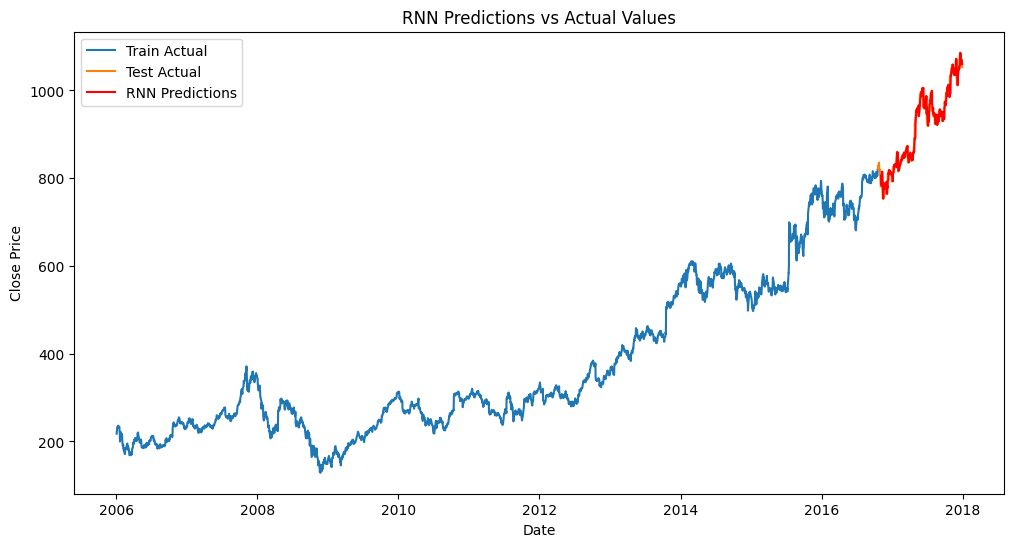

In [9]:
# Создание данных для обучения и тестирования с нормированием
look_back = 10
train_scaled, test_scaled = data_scaled[0:train_size], data_scaled[train_size:len(data_scaled)]

def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        X.append(a)
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X_train_scaled, y_train_scaled = create_dataset(train_scaled, look_back)
X_test_scaled, y_test_scaled = create_dataset(test_scaled, look_back)

# Переформирование данных для RNN
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Создание модели RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, 1), activation='relu'))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
model_rnn.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=10, verbose=2)

# Прогнозирование
train_predict_rnn = model_rnn.predict(X_train_scaled)
test_predict_rnn = model_rnn.predict(X_test_scaled)

# Обратное масштабирование
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
y_train_scaled = scaler.inverse_transform(y_train_scaled.reshape(-1, 1))
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# Оценка MAPE
train_mape_rnn = mean_absolute_percentage_error(y_train_scaled, train_predict_rnn)
test_mape_rnn = mean_absolute_percentage_error(y_test_scaled, test_predict_rnn)
print('Train MAPE for RNN: %.2f' % (train_mape_rnn * 100))
print('Test MAPE for RNN: %.2f' % (test_mape_rnn * 100))

# Визуализация результатов прогнозирования
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train)], scaler.inverse_transform(train_scaled), label='Train Actual')
plt.plot(data.index[len(train):len(train)+len(test)], scaler.inverse_transform(test_scaled), label='Test Actual')
plt.plot(data.index[len(train)+look_back+1:len(train)+look_back+1+len(test_predict_rnn)], test_predict_rnn, label='RNN Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('RNN Predictions vs Actual Values')
plt.legend()
plt.show()


Epoch 1/100
271/271 - 1s - 5ms/step - loss: 0.0010
Epoch 2/100
271/271 - 0s - 1ms/step - loss: 6.3379e-05
Epoch 3/100
271/271 - 0s - 1ms/step - loss: 5.9554e-05
Epoch 4/100
271/271 - 0s - 1ms/step - loss: 6.4130e-05
Epoch 5/100
271/271 - 0s - 1ms/step - loss: 5.8898e-05
Epoch 6/100
271/271 - 0s - 1ms/step - loss: 6.0453e-05
Epoch 7/100
271/271 - 0s - 1ms/step - loss: 6.2425e-05
Epoch 8/100
271/271 - 0s - 1ms/step - loss: 5.4040e-05
Epoch 9/100
271/271 - 0s - 1ms/step - loss: 5.5550e-05
Epoch 10/100
271/271 - 0s - 1ms/step - loss: 7.1617e-05
Epoch 11/100
271/271 - 0s - 1ms/step - loss: 6.2521e-05
Epoch 12/100
271/271 - 0s - 1ms/step - loss: 5.2950e-05
Epoch 13/100
271/271 - 0s - 1ms/step - loss: 5.3526e-05
Epoch 14/100
271/271 - 0s - 1ms/step - loss: 5.2486e-05
Epoch 15/100
271/271 - 0s - 1ms/step - loss: 6.0122e-05
Epoch 16/100
271/271 - 0s - 1ms/step - loss: 6.2721e-05
Epoch 17/100
271/271 - 0s - 1ms/step - loss: 5.1272e-05
Epoch 18/100
271/271 - 0s - 2ms/step - loss: 5.0682e-05
Epoch

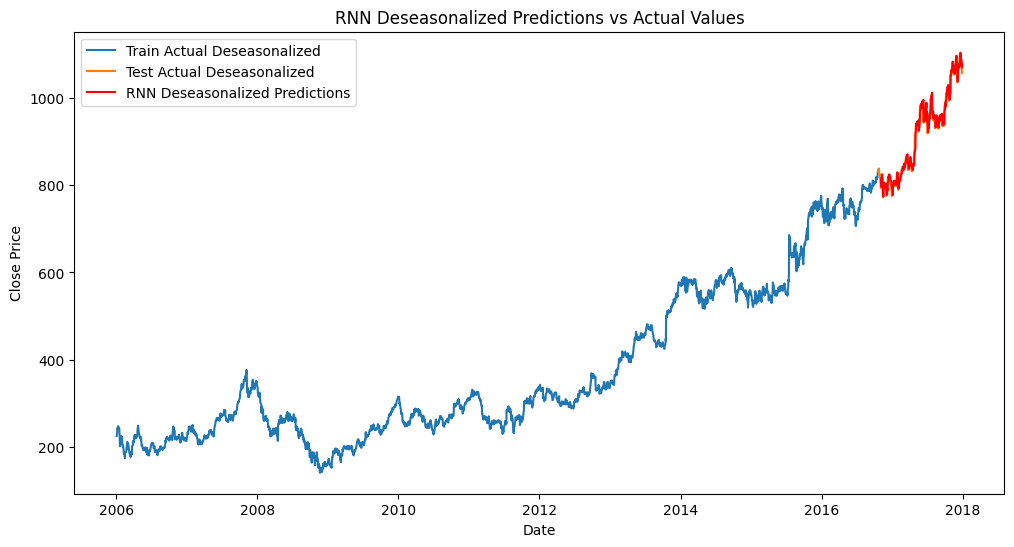

In [10]:
# Анализ работы нейронной сети на временном ряде с сезонной компонентой и без неё
# Вычитание сезонной компоненты
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=365)
seasonal = decomposition.seasonal
data_deseasonalized = data['Close'] - seasonal

# Нормализация данных с удалением сезонной компоненты
data_deseasonalized_scaled = scaler.fit_transform(data_deseasonalized.values.reshape(-1, 1))
train_deseasonalized_scaled, test_deseasonalized_scaled = data_deseasonalized_scaled[0:train_size], data_deseasonalized_scaled[train_size:len(data_deseasonalized_scaled)]
X_train_deseasonalized_scaled, y_train_deseasonalized_scaled = create_dataset(train_deseasonalized_scaled, look_back)
X_test_deseasonalized_scaled, y_test_deseasonalized_scaled = create_dataset(test_deseasonalized_scaled, look_back)

# Переформирование данных для RNN
X_train_deseasonalized_scaled = X_train_deseasonalized_scaled.reshape((X_train_deseasonalized_scaled.shape[0], X_train_deseasonalized_scaled.shape[1], 1))
X_test_deseasonalized_scaled = X_test_deseasonalized_scaled.reshape((X_test_deseasonalized_scaled.shape[0], X_test_deseasonalized_scaled.shape[1], 1))

# Создание и обучение модели RNN на данных без сезонной компоненты
model_rnn_deseasonalized = Sequential()
model_rnn_deseasonalized.add(SimpleRNN(50, input_shape=(look_back, 1), activation='relu'))
model_rnn_deseasonalized.add(Dense(1))
model_rnn_deseasonalized.compile(loss='mean_squared_error', optimizer='adam')
model_rnn_deseasonalized.fit(X_train_deseasonalized_scaled, y_train_deseasonalized_scaled, epochs=100, batch_size=10, verbose=2)

# Прогнозирование на данных без сезонной компоненты
train_predict_rnn_deseasonalized = model_rnn_deseasonalized.predict(X_train_deseasonalized_scaled)
test_predict_rnn_deseasonalized = model_rnn_deseasonalized.predict(X_test_deseasonalized_scaled)

# Обратное масштабирование прогнозов без сезонной компоненты
train_predict_rnn_deseasonalized = scaler.inverse_transform(train_predict_rnn_deseasonalized)
y_train_deseasonalized_scaled = scaler.inverse_transform(y_train_deseasonalized_scaled.reshape(-1, 1))
test_predict_rnn_deseasonalized = scaler.inverse_transform(test_predict_rnn_deseasonalized)
y_test_deseasonalized_scaled = scaler.inverse_transform(y_test_deseasonalized_scaled.reshape(-1, 1))

# Оценка MAPE для данных без сезонной компоненты
train_mape_rnn_deseasonalized = mean_absolute_percentage_error(y_train_deseasonalized_scaled, train_predict_rnn_deseasonalized)
test_mape_rnn_deseasonalized = mean_absolute_percentage_error(y_test_deseasonalized_scaled, test_predict_rnn_deseasonalized)
print('Train MAPE for RNN without seasonality: %.2f' % (train_mape_rnn_deseasonalized * 100))
print('Test MAPE for RNN without seasonality: %.2f' % (test_mape_rnn_deseasonalized * 100))

# Визуализация результатов прогнозирования без сезонной компоненты
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train)], scaler.inverse_transform(train_deseasonalized_scaled), label='Train Actual Deseasonalized')
plt.plot(data.index[len(train):len(train)+len(test)], scaler.inverse_transform(test_deseasonalized_scaled), label='Test Actual Deseasonalized')
plt.plot(data.index[len(train)+look_back+1:len(train)+look_back+1+len(test_predict_rnn_deseasonalized)], test_predict_rnn_deseasonalized, label='RNN Deseasonalized Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('RNN Deseasonalized Predictions vs Actual Values')
plt.legend()
plt.show()